In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (SimpleImputer, IterativeImputer)
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.cluster import KMeans
from category_encoders import MEstimateEncoder
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

In [3]:
full_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

test_pass_id = test_df.PassengerId.copy()

# Keep max index that will be used to back split training and test data
X_max_index = full_df.shape[0]

# Separate features and target
y = full_df.Transported.astype(int)

df = full_df.drop(['Transported'], axis=1).copy()
df = pd.concat([df, test_df], axis=0).reset_index(drop=True)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.3+ MB


In [4]:
df['Pass_group'] = df.PassengerId.str.split('_').str[0]
df.Pass_group = df.Pass_group.astype(int)
df['Lastname'] = df.Name.str.split(' ').str[1]
df[['Deck', 'Cab_num', 'Deck_side']] = df.Cabin.str.split('/', expand=True)
df.Cab_num = df.Cab_num.astype(float)

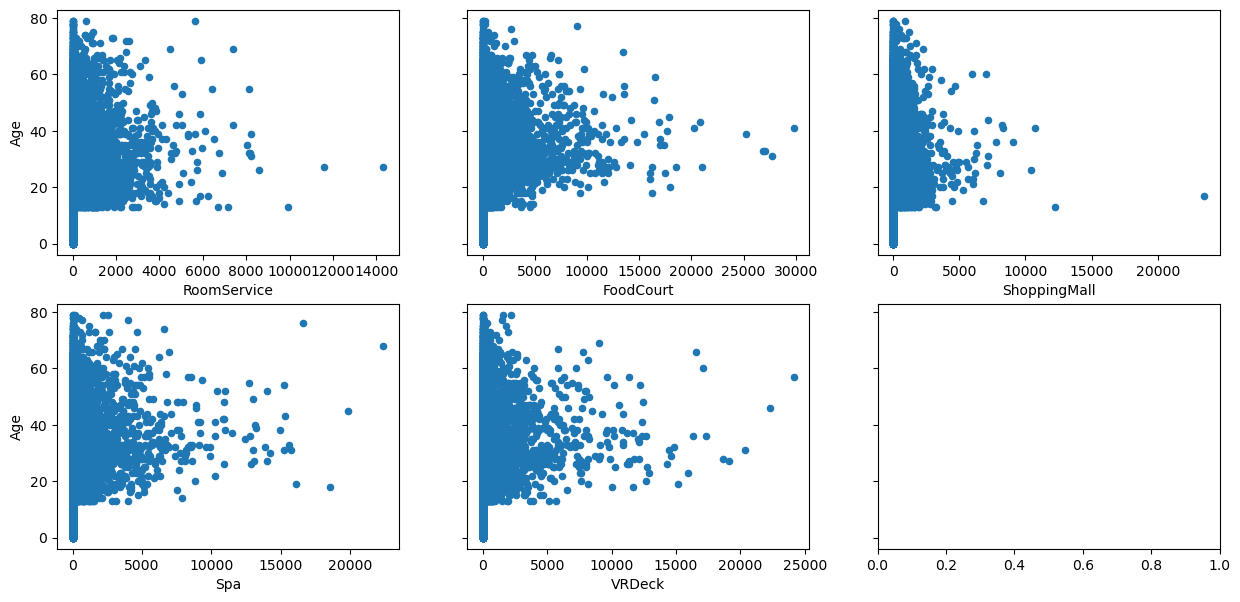

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 7))
df.plot.scatter(x='RoomService', y='Age', ax=axes[0, 0])
df.plot.scatter(x='FoodCourt', y='Age', ax=axes[0, 1])
df.plot.scatter(x='ShoppingMall', y='Age', ax=axes[0, 2])
df.plot.scatter(x='Spa', y='Age', ax=axes[1, 0])
df.plot.scatter(x='VRDeck', y='Age', ax=axes[1, 1])
plt.show()

In [6]:
df.loc[df.RoomService.gt(9000), 'RoomService'] = 9000

# Cap FoodCourt at 22000
df.loc[df.FoodCourt.gt(22000), 'FoodCourt'] = 22000

# Cap ShoppingMall at 11000
df.loc[df.ShoppingMall.gt(11000), 'ShoppingMall'] = 11000

# Cap Spa at 17000
df.loc[df.Spa.gt(17000), 'Spa'] = 17000

# Cap VRDeck at 21000
df.loc[df.VRDeck.gt(21000), 'VRDeck'] = 21000


In [7]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df.loc[df.CryoSleep.eq(True), amenities].sum()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

In [8]:
df.loc[df.CryoSleep.eq(True), amenities]=0


In [9]:
zero_amenities = df[amenities].sum(axis=1).eq(0)
df.loc[zero_amenities, amenities] =0

In [10]:
for i in amenities: 
    df.loc[df[i].isna(), i] = df.loc[df[i].gt(0), i].median()


In [11]:
df['Total_expenses'] = df[amenities].sum(axis=1)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Pass_group,Lastname,Deck,Cab_num,Deck_side,Total_expenses
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,1,Ofracculy,B,0.0,P,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,2,Vines,F,0.0,S,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,3,Susent,A,0.0,S,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,3,Susent,A,0.0,S,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,4,Santantines,F,1.0,S,1091.0


In [12]:
df.loc[(df.CryoSleep.isna() & df.Total_expenses.gt(0)), 'CryoSleep'] = False

In [13]:
df.groupby('VIP').Age.min()

VIP
False     0.0
True     18.0
Name: Age, dtype: float64

In [14]:
df.groupby(['HomePlanet', 'Destination']).VIP.value_counts()

HomePlanet  Destination    VIP  
Earth       55 Cancri e    False     956
            PSO J318.5-22  False    1043
            TRAPPIST-1e    False    4568
Europa      55 Cancri e    False    1195
                           True       83
            PSO J318.5-22  False      16
                           True       13
            TRAPPIST-1e    False    1618
                           True       78
Mars        55 Cancri e    False     290
            PSO J318.5-22  False      55
                           True        9
            TRAPPIST-1e    False    2122
                           True       81
Name: VIP, dtype: int64

In [15]:
df.loc[(df.VIP.isna()&(df.Age<18)),'VIP']=False

In [16]:
df.loc[(df.VIP.isna()&(df.HomePlanet=='Earth')),'VIP']=False

In [17]:
df.loc[(df.VIP.isna()&(df.HomePlanet=='Mars')&(df.Destination=='55 Cancri e')),'VIP']=False

In [18]:
df.loc[(df.VIP.isna() 
        & (df.Deck.isin(['G', 'T']))), 'VIP'] = False

In [19]:
df.loc[(df.HomePlanet.isna() 
        & df.VIP.eq(True) 
        & df.Destination.eq('55 Cancri e')), 'HomePlanet'] = 'Europa'

In [20]:
df.groupby('Pass_group').HomePlanet.nunique().gt(1).sum()

0

In [21]:
present_values = ~df.Pass_group.isna() & ~df.HomePlanet.isna()
present_values

0        True
1        True
2        True
3        True
4        True
         ... 
12965    True
12966    True
12967    True
12968    True
12969    True
Length: 12970, dtype: bool

In [22]:
group_home_map = (df.loc[present_values, ['Pass_group', 'HomePlanet']]
            .set_index('Pass_group').to_dict()['HomePlanet'])


In [23]:
df.loc[df.HomePlanet.isna(), 'HomePlanet'] = df.Pass_group.map(group_home_map)

In [24]:
len(df.loc[df.HomePlanet.isna(), 'HomePlanet'])

156

In [25]:
df.iloc[186]

PassengerId              0210_01
HomePlanet                   NaN
CryoSleep                   True
Cabin                      D/6/P
Destination          55 Cancri e
Age                         24.0
VIP                        False
RoomService                  0.0
FoodCourt                    0.0
ShoppingMall                 0.0
Spa                          0.0
VRDeck                       0.0
Name              Arraid Inicont
Pass_group                   210
Lastname                 Inicont
Deck                           D
Cab_num                      6.0
Deck_side                      P
Total_expenses               0.0
Name: 186, dtype: object

In [26]:
df.groupby('HomePlanet').Deck.value_counts()


HomePlanet  Deck
Earth       G       3731
            F       2437
            E        589
Europa      B       1137
            C       1096
            A        352
            D        302
            E        199
            T         10
Mars        F       1742
            E        515
            D        410
Name: Deck, dtype: int64

In [27]:
df.loc[(df.HomePlanet.isna() 
        & df.Deck.isin(['T', 'A', 'B', 'C',])), 'HomePlanet'] = 'Europa'

In [28]:
df.loc[(df.HomePlanet.isna() & df.Deck.eq('G')), 'HomePlanet'] = 'Earth'

In [29]:
df.loc[(df.HomePlanet.isna() & df.Deck.eq('G')), 'HomePlanet'] = 'Earth'

In [30]:
df.groupby('Lastname').HomePlanet.nunique().gt(1).sum()


0

In [31]:
df.isna().sum()

PassengerId         0
HomePlanet         93
CryoSleep         136
Cabin             299
Destination       274
Age               270
VIP               121
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              294
Pass_group          0
Lastname          294
Deck              299
Cab_num           299
Deck_side         299
Total_expenses      0
dtype: int64

In [32]:
present_values = ~df.Lastname.isna() & ~df.HomePlanet.isna()
lastname_home_map = (df.loc[present_values, ['Lastname', 'HomePlanet']]
            .set_index('Lastname').to_dict()['HomePlanet'])

# Impute HomePlanet from dictionary
df.loc[df.HomePlanet.isna(), 'HomePlanet'] = df.Lastname.map(lastname_home_map)

In [33]:
df.loc[((df.VIP == True) & df.Age.isna()), 'Age'] = df.loc[(df.VIP == True), 'Age'].median()

In [34]:
df.loc[(df.Age.isna() 
        & df.Total_expenses.gt(0)), 'Age'] = df.loc[df.Total_expenses.gt(0), 'Age'].median()

In [35]:
df.loc[(df.Age.isna() 
        & df.Total_expenses.eq(0)
        & df.CryoSleep.eq(False)), 'Age'] = df.loc[(df.Total_expenses.eq(0) 
                                                    & df.CryoSleep.eq(False)), 'Age'].median()

In [36]:
df.Age.fillna(df.Age.median(), inplace=True)

In [37]:
df.Cab_num.fillna(df.Cab_num.median(), inplace=True)

Group_members = df.Pass_group.value_counts().to_dict()
df['Group_members'] = df.Pass_group.map(Group_members)

In [38]:
Cabin_members = df.Cabin.value_counts().to_dict()
df['Cabin_members'] = df.Cabin.map(Cabin_members)
df.Cabin_members.fillna(df.Cabin_members.mean(), inplace=True)

In [39]:

df.isna().sum()

PassengerId         0
HomePlanet         10
CryoSleep         136
Cabin             299
Destination       274
Age                 0
VIP               121
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              294
Pass_group          0
Lastname          294
Deck              299
Cab_num             0
Deck_side         299
Total_expenses      0
Group_members       0
Cabin_members       0
dtype: int64

In [40]:
X = df[:X_max_index]
test_df = df[X_max_index:]
full_df = pd.concat([X, y], axis=1).copy()
deck_total_pass = full_df.groupby('Deck').Deck.count()

deck_total_transported = full_df.groupby('Deck').Transported.sum()
Deck_transp_ratio = (deck_total_transported / deck_total_pass).to_dict()

df['Deck_transp_ratio'] = df.Deck.map(Deck_transp_ratio)
df.Deck_transp_ratio.fillna(df.Deck_transp_ratio.mean(), inplace=True)

In [41]:
# Total passengers by Deck_side
deck_side_total = full_df.groupby('Deck_side').Deck.count()

# Total Transported by Deck_side
deck_side_transported = full_df.groupby('Deck_side').Transported.sum()

# Dictionary with Deck_side_transp_ratio
Deck_side_transp_ratio = (deck_side_transported / deck_side_total).to_dict()

# Create Deck_side_transp_ratio
df['Deck_side_transp_ratio'] = df.Deck_side.map(Deck_side_transp_ratio)
df.Deck_side_transp_ratio.fillna(df.Deck_side_transp_ratio.mean(), inplace=True)

In [42]:
col_drop = ['PassengerId', 'Cabin', 'Name', 'Lastname']
df = df.drop(col_drop, axis=1)

In [43]:
df.isna().sum()

HomePlanet                 10
CryoSleep                 136
Destination               274
Age                         0
VIP                       121
RoomService                 0
FoodCourt                   0
ShoppingMall                0
Spa                         0
VRDeck                      0
Pass_group                  0
Deck                      299
Cab_num                     0
Deck_side                 299
Total_expenses              0
Group_members               0
Cabin_members               0
Deck_transp_ratio           0
Deck_side_transp_ratio      0
dtype: int64

In [44]:
categ_cols = list(df.select_dtypes(['object', 'category']).columns)
cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
df_cat = pd.DataFrame(cat_imputer.fit_transform(df[categ_cols]), 
                      columns=df[categ_cols].columns)
df_cat = pd.get_dummies(df_cat)

In [45]:
categ_cols

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Deck_side']

In [46]:
pd.DataFrame(cat_imputer.fit_transform(df[categ_cols]), 
                      columns=df[categ_cols].columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   HomePlanet   12970 non-null  object
 1   CryoSleep    12970 non-null  object
 2   Destination  12970 non-null  object
 3   VIP          12970 non-null  object
 4   Deck         12970 non-null  object
 5   Deck_side    12970 non-null  object
dtypes: object(6)
memory usage: 608.1+ KB


In [47]:
df_cat.isna().sum()

HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
HomePlanet_Missing           0
CryoSleep_False              0
CryoSleep_True               0
CryoSleep_Missing            0
Destination_55 Cancri e      0
Destination_Missing          0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
VIP_False                    0
VIP_True                     0
VIP_Missing                  0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_Missing                 0
Deck_T                       0
Deck_side_Missing            0
Deck_side_P                  0
Deck_side_S                  0
dtype: int64

In [48]:
df.isna().sum()

HomePlanet                 10
CryoSleep                 136
Destination               274
Age                         0
VIP                       121
RoomService                 0
FoodCourt                   0
ShoppingMall                0
Spa                         0
VRDeck                      0
Pass_group                  0
Deck                      299
Cab_num                     0
Deck_side                 299
Total_expenses              0
Group_members               0
Cabin_members               0
Deck_transp_ratio           0
Deck_side_transp_ratio      0
dtype: int64

In [49]:
df_cat.head()



,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Missing,CryoSleep_False,CryoSleep_True,CryoSleep_Missing,Destination_55 Cancri e,Destination_Missing,Destination_PSO J318.5-22,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Missing,Deck_T,Deck_side_Missing,Deck_side_P,Deck_side_S
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [50]:
num_cols = list(df.select_dtypes(['int64', 'float64']).columns)

# Concatenate with encoded categorical columns
df = pd.concat([df_cat, df[num_cols]], axis=1)

# Impute numericals
it_imp = IterativeImputer()
df = pd.DataFrame(it_imp.fit_transform(df), columns=df.columns)
df.isna().sum()

HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
HomePlanet_Missing           0
CryoSleep_False              0
CryoSleep_True               0
CryoSleep_Missing            0
Destination_55 Cancri e      0
Destination_Missing          0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
VIP_False                    0
VIP_True                     0
VIP_Missing                  0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_Missing                 0
Deck_T                       0
Deck_side_Missing            0
Deck_side_P                  0
Deck_side_S                  0
Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Pass_gro

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HomePlanet_Earth           12970 non-null  float64
 1   HomePlanet_Europa          12970 non-null  float64
 2   HomePlanet_Mars            12970 non-null  float64
 3   HomePlanet_Missing         12970 non-null  float64
 4   CryoSleep_False            12970 non-null  float64
 5   CryoSleep_True             12970 non-null  float64
 6   CryoSleep_Missing          12970 non-null  float64
 7   Destination_55 Cancri e    12970 non-null  float64
 8   Destination_Missing        12970 non-null  float64
 9   Destination_PSO J318.5-22  12970 non-null  float64
 10  Destination_TRAPPIST-1e    12970 non-null  float64
 11  VIP_False                  12970 non-null  float64
 12  VIP_True                   12970 non-null  float64
 13  VIP_Missing                12970 non-null  flo

In [52]:
X = df[:X_max_index]
full_df = pd.concat([X, y], axis=1)
full_df['Non_zero_expenses'] = full_df.loc[full_df.Total_expenses.gt(0), 'Total_expenses']

In [53]:
def transported_chance_by(feature, xticks=None, xlim=None):
    transported = full_df[full_df.Transported == 1]
    not_transported = full_df[full_df.Transported == 0]

    plt.figure(figsize=(10, 5))

    transported[feature].plot(kind='kde', label='transported')
    not_transported[feature].plot(kind='kde', label='not_transported')
    
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

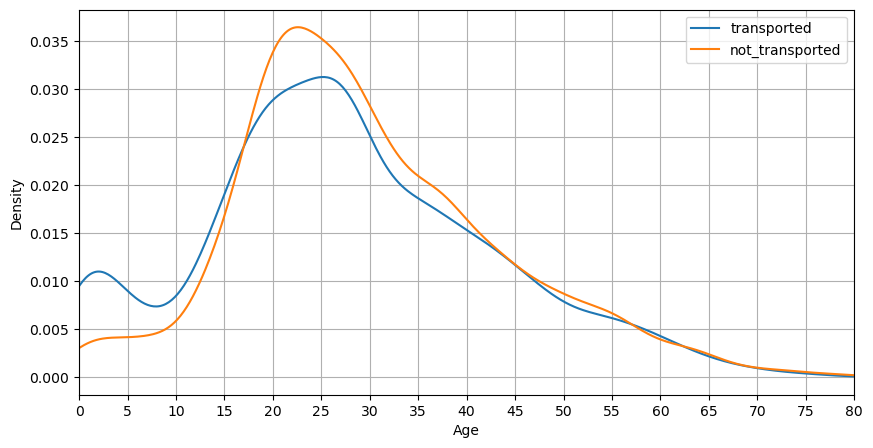

In [54]:
transported_chance_by('Age', np.arange(0, 81, 5), (0, 80))

In [55]:
df['Age_group'] = pd.cut(x=df.Age, labels=[1, 3, 2],
                         bins=[-1, 17, 43, df.Age.max()]).astype('float')

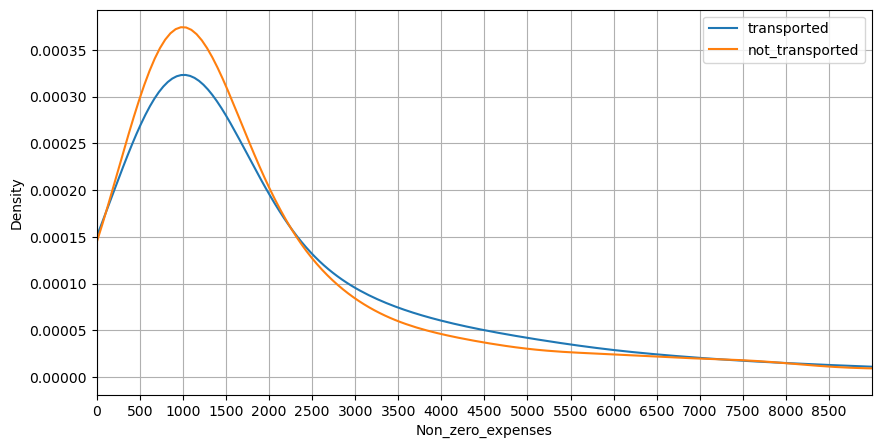

In [56]:
transported_chance_by('Non_zero_expenses', np.arange(0, 9000, 500), (0, 9000))

In [57]:
# Create Total_expenses_group feature additionally separating 0 expenses group
df['Total_expenses_group'] = pd.cut(x=df.Total_expenses, labels=[3, 1, 2],
                         bins=[-1, 1, 2250, df.Total_expenses.max()]).astype('float')

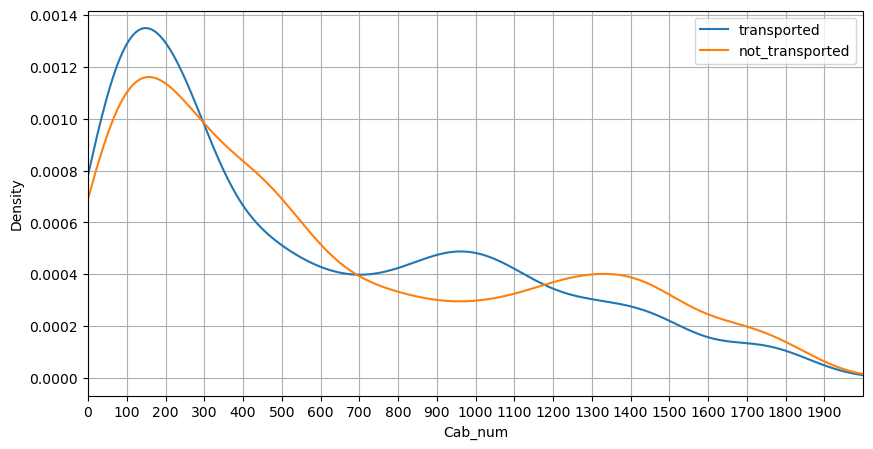

In [58]:
# Transported by Cab_num
transported_chance_by('Cab_num', np.arange(0, 2000, 100), (0, 2000))

In [59]:
# Create Cab_group feature
df['Cab_group'] = pd.cut(x=df.Cab_num, labels=[3, 2, 4, 1],
                         bins=[-1, 300, 690, 1170, df.Cab_num.max()]).astype('float')

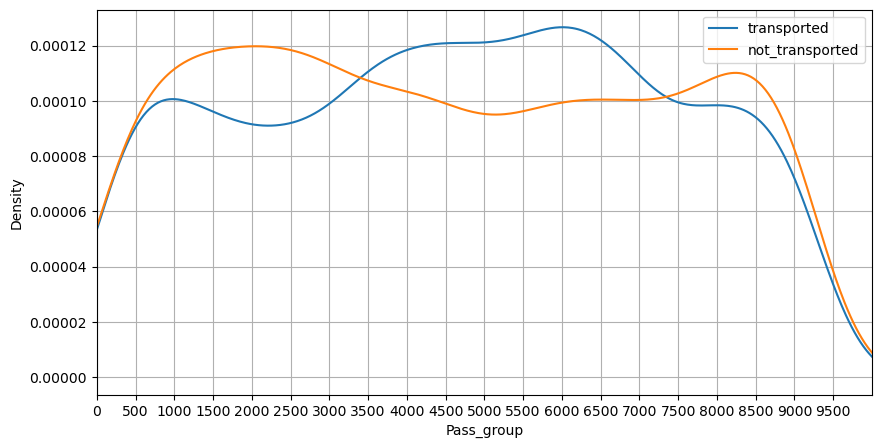

In [60]:
# Transported by Pass_group
transported_chance_by('Pass_group', np.arange(0, 10000, 500), (0, 10000))

In [61]:
# Create Pass_group_type feature
df['Pass_group_type'] = pd.cut(x=df.Pass_group, labels=[2, 3, 1], 
                               bins=[-1, 3400, 7300, df.Pass_group.max()]).astype('float')

In [62]:
# Apply np.log to normalize the skewed right data
skewed_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 
                   'Spa', 'VRDeck', 'Total_expenses']
df[skewed_features] = df[skewed_features].apply(np.log1p)

# Standardize 
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

In [63]:
# Drop columns not used for modeling
col_drop = ['Cab_num', 'Pass_group']
df = df.drop(col_drop, axis=1)

In [64]:
X = df[:X_max_index]
test_df = df[X_max_index:]

In [65]:
df.iloc[2]

HomePlanet_Earth            -1.084853
HomePlanet_Europa            1.748407
HomePlanet_Mars             -0.518849
HomePlanet_Missing          -0.027778
CryoSleep_False              0.756009
CryoSleep_True              -0.738967
CryoSleep_Missing           -0.102941
Destination_55 Cancri e     -0.505656
Destination_Missing         -0.146907
Destination_PSO J318.5-22   -0.316951
Destination_TRAPPIST-1e      0.679755
VIP_False                   -5.649671
VIP_True                     6.819762
VIP_Missing                 -0.097042
Deck_A                       5.969792
Deck_B                      -0.310577
Deck_C                      -0.304721
Deck_D                      -0.242437
Deck_E                      -0.337033
Deck_F                      -0.696786
Deck_G                      -0.641459
Deck_Missing                -0.153614
Deck_T                      -0.029135
Deck_side_Missing           -0.153614
Deck_side_P                 -0.970369
Deck_side_S                  1.016168
Age         

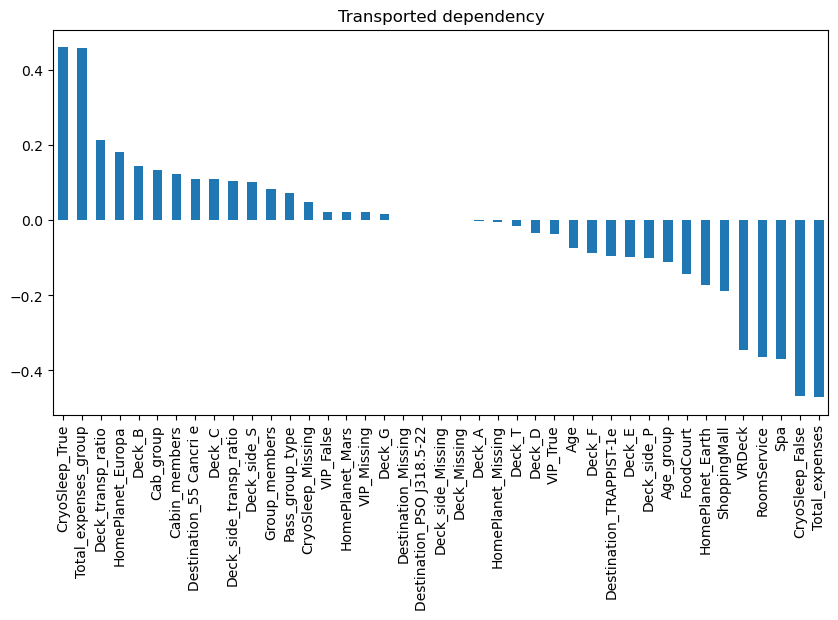

In [66]:
full_df = pd.concat([X, y], axis=1)

correlation = full_df.corr()['Transported'].sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Transported dependency')
plt.show()

In [67]:
final_features = [
    'HomePlanet_Earth', 'HomePlanet_Mars', 'HomePlanet_Missing', 'CryoSleep_True',
    'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A', 'Deck_Missing',
    'Deck_T', 'Deck_side_P', 'Age', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck',
    'Total_expenses', 'Group_members', 'Deck_transp_ratio', 'Total_expenses_group', 'Cab_group']

In [68]:
params =  {'depth': 6,
           'iterations': 2000, 
           'learning_rate': 0.01, 
           'thread_count': -1, 
           'verbose': False}

In [69]:
# Define and fit the final model
cat_model = CatBoostClassifier(**params)
cat_model.fit(X[final_features], y)

# Check accuracy and features importance
cat_rmses = cross_val_score(cat_model, X[final_features], y, cv=5)

print(pd.Series(cat_rmses).describe())
print('\n', cat_model.get_feature_importance(prettified=True))

count    5.000000
mean     0.820547
std      0.020048
min      0.798160
25%      0.808400
50%      0.814261
75%      0.834388
max      0.847526
dtype: float64

                    Feature Id  Importances
0           Deck_transp_ratio    14.877241
1                         Spa    11.855024
2              Total_expenses    11.818839
3                      VRDeck    10.299987
4            HomePlanet_Earth     8.353149
5                 RoomService     7.879916
6        Total_expenses_group     6.008547
7                 Deck_side_P     5.461562
8                   Cab_group     5.195473
9                         Age     4.798363
10            HomePlanet_Mars     3.859631
11               ShoppingMall     2.883405
12             CryoSleep_True     2.509545
13    Destination_TRAPPIST-1e     2.097822
14              Group_members     1.385488
15  Destination_PSO J318.5-22     0.314012
16                     Deck_A     0.266741
17               Deck_Missing     0.129117
18         HomePlanet_

In [70]:
test_preds = cat_model.predict(test_df[final_features])

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'PassengerId': test_pass_id,
                       'Transported': test_preds.astype(bool)})


In [71]:
output.to_csv('submission.csv.',index=False)

In [72]:
ls


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
__notebook__.ipynb  catboost_info/  submission.csv.


In [73]:
#!pip install kaggle

In [74]:
#!kaggle competitions submit -c Spaceship Titanic -f ./pred.csv -m "My submission"
